In [29]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score, balanced_accuracy_score,confusion_matrix, accuracy_score, log_loss
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, SplineTransformer
from sklearn.compose import ColumnTransformer
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [30]:
df = pd.read_csv('data/clean/Cleaned_Data.csv')
df = df.dropna(subset=df.columns.drop('label'))
df['log_followers_count'] = np.log(df['followers_count']+1)
df['log_length'] = np.log(df['length']+1)

## Top Scores

In [31]:
artist_summary = df.groupby('artist')['score'].filter(
#filter for artists with more than 5 reviews
    lambda x: len(x) > 5
).groupby(df['artist']).agg(['mean', 'median']).sort_values(
    by='mean', ascending=False
).head(5)
print(artist_summary)

genre_summary = df.groupby('main_genre')['score'].filter(
#filter for genres with more than 40 reviews
    lambda x: len(x) > 40   
).groupby(df['main_genre']).agg(['mean', 'median']).sort_values(
    by='mean', ascending=False
).head(5)
print(genre_summary)

                       mean  median
artist                             
Stevie Wonder      9.000000    9.45
Talking Heads      8.983333    8.70
Alice Coltrane     8.950000    8.65
Prince             8.710000    8.60
Bruce Springsteen  8.570000    8.65
                  mean  median
main_genre                    
Jazz          7.751839     7.7
Experimental  7.540832     7.6
Metal         7.482000     7.6
Folk/Country  7.472807     7.5
Rock          7.374112     7.4


## Score by Follower Count

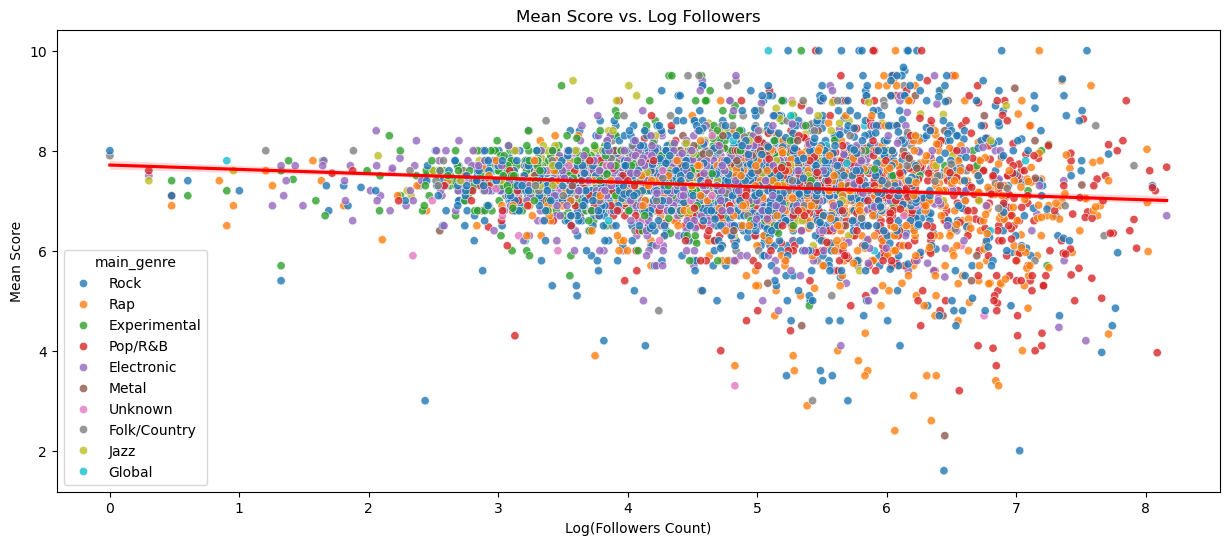

In [32]:
#take average score by artist
artist_df = df.groupby('artist')[['followers_count', 'score', 'main_genre']].agg({
    'followers_count': 'mean',
    'score': 'mean',
    'main_genre': 'first'
}).reset_index()
#Log transform followers
artist_df['log_followers'] = np.log10(artist_df['followers_count']+1)

#scatterplot (with color by genre)
plt.figure(figsize=(15, 6))
sns.scatterplot(
    data=artist_df, 
    x='log_followers', 
    y='score', 
    hue='main_genre',
    palette='tab10',
    alpha=0.8
)
#add regression line
sns.regplot(
    data=artist_df, 
    x="log_followers", 
    y="score", 
    scatter=False, 
    color="red"
)

plt.title("Mean Score vs. Log Followers")
plt.xlabel("Log(Followers Count)")
plt.ylabel("Mean Score")

if not os.path.exists("Visualizations/pitchfork_followers_by_artist.png"):
    plt.savefig("Visualizations/pitchfork_followers_by_artist.png")

plt.show()

## Score vs Log(Length) by Album Age

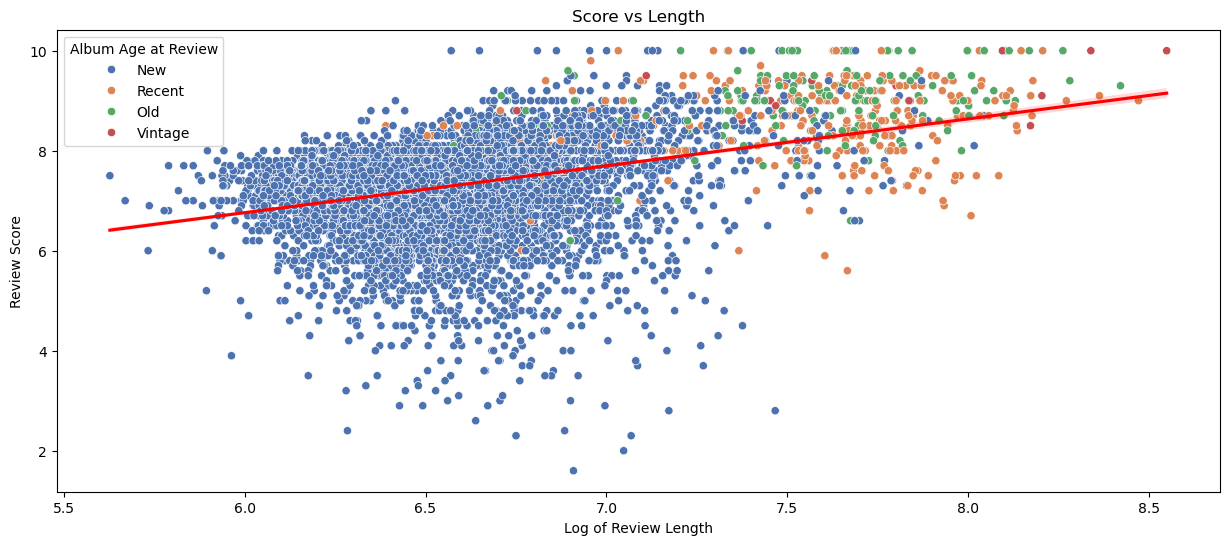

In [33]:
#create new column for album ages as categories
df['age_category'] = pd.cut(df['review_release_difference'], bins=4, labels=["New", "Recent", "Old", "Vintage"])

#plot score by log(length) colored by age
plt.figure(figsize=(15, 6))
sns.scatterplot(
    data=df, 
    x="log_length", 
    y="score", 
    hue="age_category",
    palette="deep",
)
#add line of best fit
sns.regplot(
    data=df, 
    x="log_length", 
    y="score", 
    scatter=False, 
    color="red"
)
plt.title("Score vs Length")
plt.xlabel("Log of Review Length")
plt.ylabel("Review Score")
plt.legend(title="Album Age at Review")

#save image
if not os.path.exists("Visualizations/pitchfork_album_age.png"):
    plt.savefig("Visualizations/pitchfork_album_age.png")
plt.show()

## Boxplots of Score by Genre

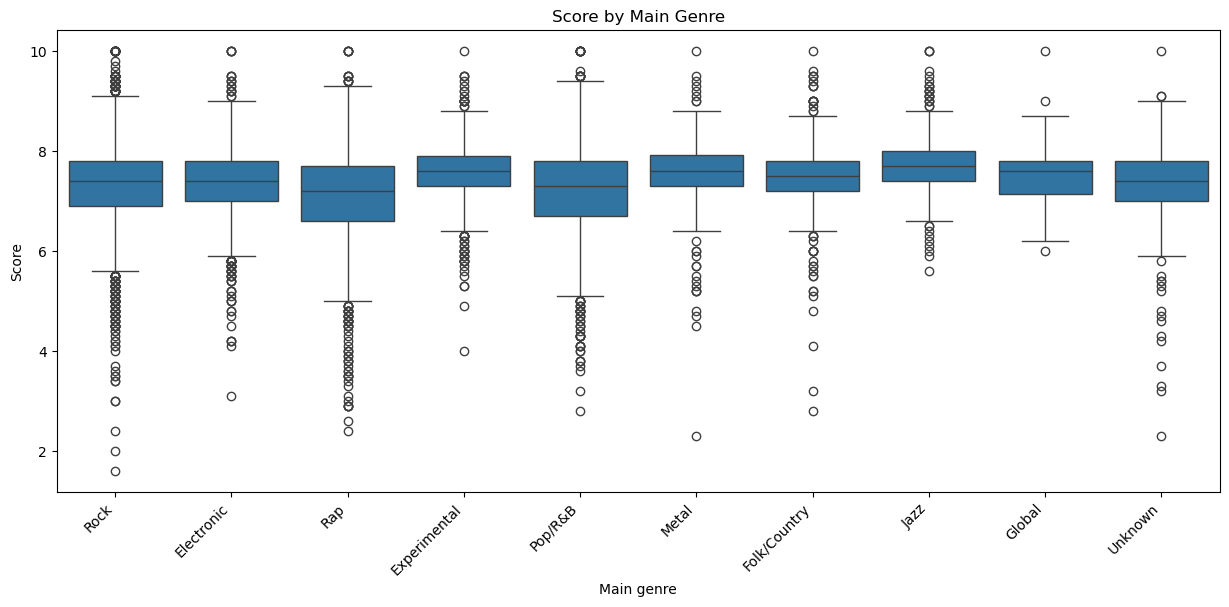

In [34]:
# Boxplots of score by genre (using main_genre)
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x="main_genre", y="score")
plt.title("Score by Main Genre")
plt.xlabel("Main genre")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.show()

## Regression Coefficients

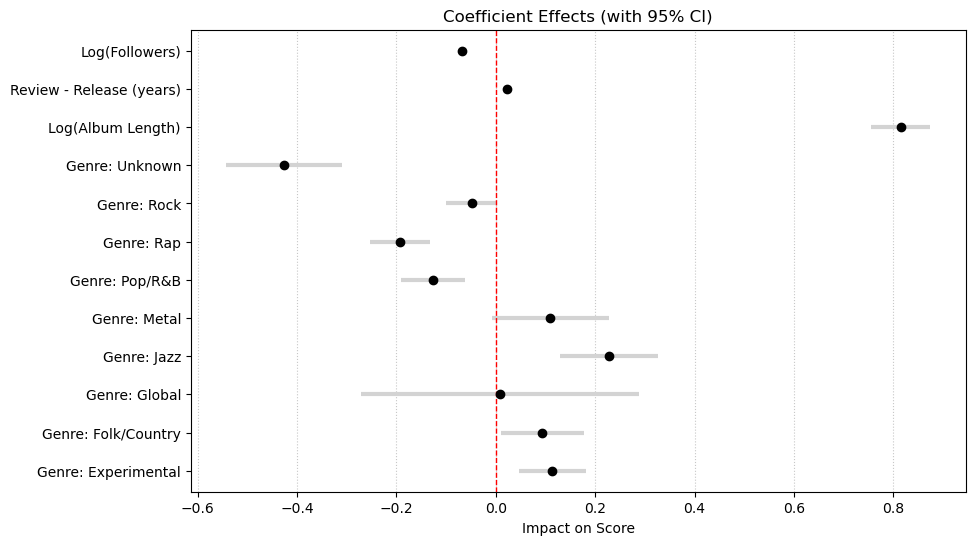

In [35]:
# Fit the model
results = smf.ols('score ~ log_length + review_release_difference + log_followers_count + main_genre', data=df).fit()

# Extract the coefficients table
df_results = results.summary2().tables[1]

# Get params and confidence intervals
params = results.params.drop("Intercept")
conf_int = results.conf_int().drop("Intercept")
errors = params - conf_int[0]

rename_dict = {
    'log_followers_count': 'Log(Followers)',
    'review_release_difference': 'Review - Release (years)',
    'log_length': 'Log(Album Length)',
    'main_genre[T.Unknown]': 'Genre: Unknown',
    'main_genre[T.Rock]': 'Genre: Rock',
    'main_genre[T.Rap]': 'Genre: Rap',
    'main_genre[T.Pop/R&B]': 'Genre: Pop/R&B',
    'main_genre[T.Metal]': 'Genre: Metal',
    'main_genre[T.Jazz]': 'Genre: Jazz',
    'main_genre[T.Global]': 'Genre: Global',
    'main_genre[T.Folk/Country]': 'Genre: Folk/Country',
    'main_genre[T.Experimental]': 'Genre: Experimental',
    'main_genre[T.Electronic]': 'Genre: Electronic' # Add any others that might be missing
}

#Rename the index of the params Series
params.rename(index=rename_dict, inplace=True)

plt.figure(figsize=(10, 6))
plt.errorbar(params, params.index, xerr=errors, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.title('Coefficient Effects (with 95% CI)')
plt.xlabel('Impact on Score')
plt.grid(axis='x', linestyle=':', alpha=0.7)
plt.show()

# PCA

Principal Component Analysis (PCA) is a method that takes several numeric variables and transforms them into a smaller number of new variables called principal components. Each principal component is a combination of the original features, and they are created in a way that the first component captures the most variation in the data, the second captures the next most, and so on. The goal is to reduce the complexity of the dataset while still keeping the major patterns.

In [36]:
features = [
    "score",
    "log_followers_count",
    "length",
    "review_year",
    "review_release_difference",
    "reviewer_reviews",
    "artist_reviews",
    "genre_len"
]
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained = pca.explained_variance_ratio_

In this project, PCA was applied to numeric features such as score, log followers, review length, review year, review-release difference, reviewer activity, artist activity, and the number of genres. Before applying PCA, all variables were standardized so that differences in scale (for example, followers being in millions and review length being in hundreds of words) do not distort the analysis.

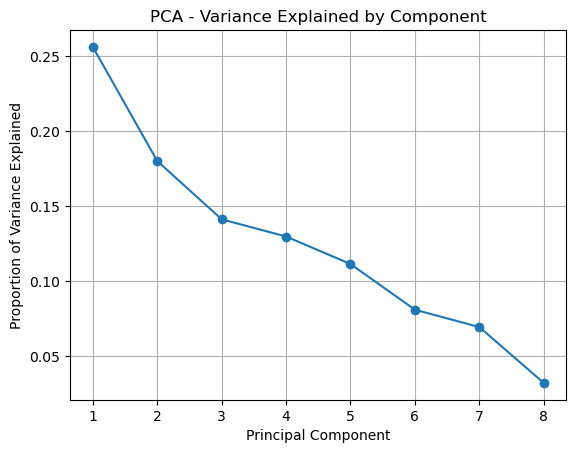

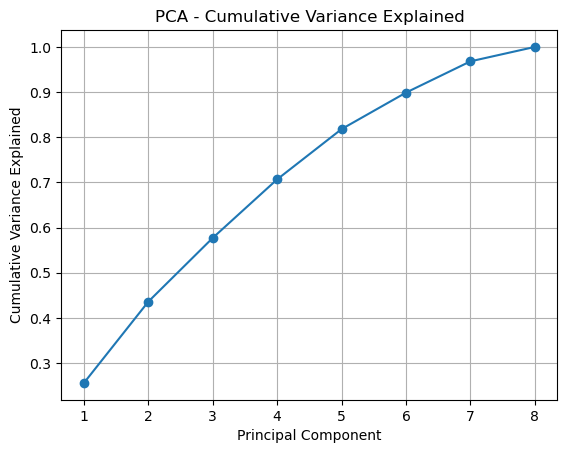

In [37]:
# Scree Plot, Plot variance explained 

plt.figure()
plt.plot(range(1, len(explained) + 1), explained, marker="o")
plt.title("PCA - Variance Explained by Component")
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(range(1, len(explained) + 1), explained.cumsum(), marker="o")
plt.title("PCA - Cumulative Variance Explained")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Variance Explained")
plt.grid(True)
plt.show()

1. 

The variance explained plot shows that PC1 captures the largest share of variation at around 25%, while PC2 and PC3 each explain roughly 10–15%. The remaining components contribute smaller but still meaningful amounts. This indicates that the dataset does not have a single dominant direction of variation, and multiple dimensions are required to describe the structure of the numerical features.

2.

The cumulative variance plot shows that the first five principal components together explain almost 80% of the total variance. So most of the meaningful variation in the dataset can be summarized using a reduced set of components instead of all original numeric features. Using two or three components preserves a moderate amount of information, while using five captures a substantial majority.


The variance explained plots show how much of the total variability each component captures. PC1 explains around 25% of the variance, and the next few components explain between 10% and 15% each. This indicates that no single feature or dimension is dominating the behavior of the data. Instead, multiple factors contribute meaningful information. By the time we reach five components, nearly 80% of the total variation in the dataset is retained. This means that the original eight numeric features can effectively be reduced to five components without losing too much information.

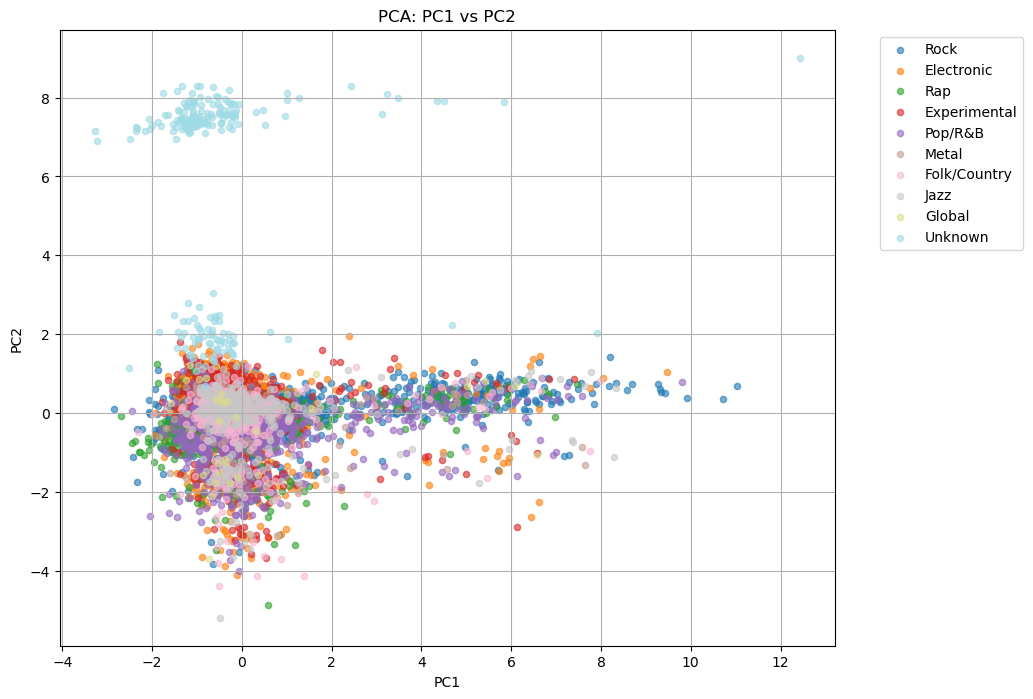

In [38]:
PC1 = X_pca[:, 0]
PC2 = X_pca[:, 1]

genres = df.loc[X.index, "main_genre"]

# Gets unique genre list + color map
unique_genres = genres.unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_genres)))

plt.figure(figsize=(10, 8))
for genre, color in zip(unique_genres, colors):
    mask = (genres == genre)
    plt.scatter(PC1[mask], PC2[mask], label=genre, alpha=0.6, s=20, color=color)

plt.title("PCA: PC1 vs PC2")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.show()


The PC1 vs PC2 scatter plot shows significant overlap between genres which means genre does not form any notable clusters in the space defined by the first two principal components. Albums from different genres share similar patterns in popularity, review length, review timing, and other numeric features, which suggests that genre alone is not a strong differentiator in this reduced dimensional representation.


This shows that the numeric features used in PCA do not cluster albums cleanly by genre. In other words, review length, timing, popularity, and reviewer/artist history vary within genres just as much as across genres. This supports earlier conclusions that genre is not strongly tied to these numerical characteristics.


In [39]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(len(features))],
    index=features
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
score,0.434270,0.128301,-0.427153,0.092733,-0.281012,-0.426158,0.578118,-0.095340
log_followers_count,0.201965,-0.320641,0.677413,-0.021444,0.349353,-0.127038,0.465832,-0.204609
length,0.627743,0.056539,0.090535,0.006155,0.151706,0.144400,-0.117164,0.732745
review_year,0.071320,-0.168400,-0.469220,-0.558666,0.642606,-0.088009,-0.043627,-0.108114
review_release_difference,0.605468,0.069434,0.055928,0.026843,-0.094210,0.183049,-0.446166,-0.619106
reviewer_reviews,-0.038727,0.168015,-0.201720,0.774380,0.566388,0.041858,0.010664,-0.085175
artist_reviews,-0.028059,0.658514,0.060642,-0.245049,0.095219,0.564634,0.405326,-0.098382
genre_len,0.050929,-0.618452,-0.287735,0.135506,-0.155850,0.647752,0.263975,-0.014673


The loadings show how each original variable contributes to each principal component. PC1 is mainly influenced by review length and review release difference, meaning it reflects patterns in how long and how delayed reviews tend to be. PC2 is dominated by log followers and negatively by artist review counts, which represents a popularity dimension. PC3 is strongly associated with review year, separating older and newer releases. The presence of multiple moderately strong loadings confirms that several factors jointly shape the PCA structure.




Overall, PCA reveals that the structure of the data is shaped by several different factors: popularity (followers), review behavior (length and delay), time (review year), and reviewer or artist activity. No single factor dominates, and genre is not a major separator in numeric space. PCA therefore helps confirm the complexity of the dataset and provides a lower dimensional representation that summarizes the main axes of variation while preserving most of the important information.


## Logistic Regression

In [40]:
numeric_features = ['score', 'album_year', 'length', 'followers_count', 
                    'reviewer_reviews', 'review_release_difference']
categorical_features = []
target = 'main_genre'

#Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Train-Test
X = df[numeric_features + categorical_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Fit the model
model = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
model.fit(X_train, y_train)
preds = model.predict(X_test)
probs = model.predict_proba(X_test)

# 7. Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, preds))

print("\nAccuracy Score:")
print(accuracy_score(y_test, preds))

print("\nLog Loss:")
print(log_loss(y_test, probs))

Confusion Matrix:
[[ 52   0   0   0   0   0   1   7 194   0]
 [ 21   0   0   0   0   0   0   0 154   0]
 [  0   0   0   0   0   0   3   0  90   0]
 [  0   0   0   0   0   0   0   0   7   0]
 [  2   0   0   0   0   0   0   0  55   0]
 [  0   0   0   0   0   0   0   1  31   0]
 [  1   0   0   0   0   0  26  22 216   0]
 [  0   0   0   0   0   0   9  31 249   0]
 [ 16   0   0   0   0   0   3   5 530   0]
 [  4   0   0   0   0   0   0   1  28   0]]

Accuracy Score:
0.3632745878339966

Log Loss:
1.7787368471972298


## K-Means

In [55]:
#define features
numeric_features = ['score', 'log_length', 'log_followers_count', 
                    'reviewer_reviews','artist_reviews']
categorical_features = ['label']

#prepare data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])
X = df[numeric_features + categorical_features]
true_labels = df['main_genre']
X_processed = preprocessor.fit_transform(X)

#set up data to plot
kmeans = KMeans(n_clusters=len(set(true_labels)), random_state=42)
cluster_labels = kmeans.fit_predict(X_processed)
plot_df = X.copy().reset_index(drop=True)
plot_df['True Genre'] = true_labels.reset_index(drop=True)
plot_df['Cluster'] = cluster_labels.astype(str)

#plot the clusters
fig = px.scatter(
    plot_df, 
    x='log_length', 
    y='score', 
    color='Cluster',
    title='K-Means Clusters (log length vs score)',
    labels={'Cluster': 'Cluster Label'},
    hover_data=['True Genre', 'reviewer_reviews'] 
)
fig.update_traces(marker=dict(size=8, line=dict(width=1, color='DarkSlateGrey')))
fig.show()

## K-Means with PCA

In [64]:
numeric_cols = ['score', 'log_length', 'log_followers_count']
categorical_cols = []#'main_genre']
true_label_col = 'main_genre'

# 1. Prepare Data
features = numeric_cols + categorical_cols
X = df[features]
true_labels = df[true_label_col]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

X_processed = preprocessor.fit_transform(X)

# 2. Clustering
n_clusters = 20#len(set(true_labels))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_processed)

# --- NEW STEP: Dimensionality Reduction (PCA) ---
# Compress the processed data into 2 latent features
pca = PCA(n_components=2)
latent_components = pca.fit_transform(X_processed)

# Calculate how much info these 2 features capture
explained_variance = pca.explained_variance_ratio_.sum() * 100

# 3. Setup Plot Data
plot_df = X.copy().reset_index(drop=True)
plot_df['True Genre'] = true_labels.reset_index(drop=True)
plot_df['Cluster'] = cluster_labels.astype(str)

# Add the new latent features to the dataframe
plot_df['Latent Feature 1'] = latent_components[:, 0]
plot_df['Latent Feature 2'] = latent_components[:, 1]

# Add hover data if available
for col in ['reviewer_reviews']:
    if col not in plot_df.columns and col in df.columns:
        plot_df[col] = df[col].reset_index(drop=True)

# 4. Plot using Latent Features as axes
fig = px.scatter(
    plot_df, 
    x='Latent Feature 1', 
    y='Latent Feature 2', 
    color='Cluster',
    title=f'K-Means Clusters on Latent Features (PCA) - {explained_variance:.1f}% Variance Captured',
    labels={'Cluster': 'Cluster Label'},
    hover_data=['True Genre', 'reviewer_reviews', 'score', 'log_length'] 
)

fig.update_traces(marker=dict(size=8, line=dict(width=1, color='DarkSlateGrey')))
fig.show()

## KNN

In [42]:
#set features for KNN
numeric_features = ['score', 'album_year', 'length', 'followers_count', 
                    'reviewer_reviews', 'artist_reviews']
categorical_features = ['label']

#prepare data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("knn", KNeighborsClassifier(weights="distance"))
])

# Train-Test
X = df[numeric_features + categorical_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {"knn__n_neighbors": range(1, 41, 2)}

#set up for cross-validation (5 folds)
grid = GridSearchCV(pipe, param_grid, cv=5, scoring="balanced_accuracy", n_jobs=-1)
grid.fit(X_train, y_train)

results_df = pd.DataFrame(grid.cv_results_)

results_df["k"] = results_df["param_knn__n_neighbors"]
results_df["mean_score"] = results_df["mean_test_score"]

best_k = grid.best_params_["knn__n_neighbors"]
best_score = grid.best_score_

#plot the best K to use
fig = px.line(
    results_df,
    x="k",
    y="mean_score",
    title=f"Cross-Validated Balanced Accuracy vs. K (best k = {best_k})",
    markers=True,
    labels={"k": "Number of Neighbors (k)", "mean_score": "Mean CV Balanced Accuracy"}
)
fig.add_scatter(
    x=[best_k],
    y=[best_score],
    mode="markers+text",
    text=[f"Best k = {best_k}"],
    textposition="top center",
    name="Best k"
)

fig.update_layout(hovermode="x unified")
fig.show()


pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)

#show KNN stats
print(f"Accuracy: {acc:.3f}")
print(f"Balanced accuracy: {bal_acc:.3f}")
confusion_matrix(y_test, y_pred, labels=pipe.classes_)

Accuracy: 0.516
Balanced accuracy: 0.419


array([[126,  30,   2,   0,   2,   1,  21,  20,  51,   1],
       [ 43,  55,   8,   0,   9,   1,   4,   7,  48,   0],
       [  6,   7,  15,   1,   1,   1,   8,   9,  45,   0],
       [  1,   1,   0,   0,   0,   0,   1,   1,   3,   0],
       [ 10,   5,   0,   0,  22,   0,   4,   4,  12,   0],
       [  3,   1,   1,   0,   1,  15,   2,   0,   9,   0],
       [ 19,   7,   4,   0,   4,   0, 104,  45,  82,   0],
       [ 25,   9,   5,   0,   2,   0,  35, 155,  58,   0],
       [ 33,  20,  19,   0,   5,   4,  39,  42, 392,   0],
       [  1,   2,   0,   0,   0,   1,   0,   1,   4,  24]])

## Elastic Net Regression

In [49]:
#Select features
X = df[['album_year', 'length', 'followers_count', 
              'reviewer_reviews', 'artist_reviews', 'main_genre', 'review_release_difference', 'review_year','age_category','log_length']]
y = df['score']

#Train-Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Preprocess data
numeric_features = ['album_year', 'length', 'followers_count', 
                    'reviewer_reviews', 'artist_reviews','review_release_difference', 'review_year', 'log_length']
categorical_features = ['main_genre', 'age_category']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

#create elastic net model that tests many L1 ratios (percetange of Lasso penalty)
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ElasticNetCV(
        l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], 
        cv=5, 
        random_state=42,
        n_jobs=-1
    ))
])
pipe.fit(X_train, y_train)

#Evaluate regression statistics
y_pred = pipe.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
best_alpha = pipe.named_steps['regressor'].alpha_
best_l1 = pipe.named_steps['regressor'].l1_ratio_

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Best Alpha found: {best_alpha:.4f}")
print(f"Best L1 Ratio found: {best_l1}")
feature_names = pipe.named_steps['preprocessor'].get_feature_names_out()

# Get coefficients
coefficients = pipe.named_steps['regressor'].coef_
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
coef_df['Abs_Coeff'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coeff', ascending=False).drop('Abs_Coeff', axis=1)

print("\nCoefficient Impacts")
print(coef_df.head(30))

Mean Squared Error: 0.6060
R² Score: 0.2511
Best Alpha found: 0.0035
Best L1 Ratio found: 0.1

Coefficient Impacts
                           Feature  Coefficient
15             cat__main_genre_Rap    -0.282178
12            cat__main_genre_Jazz     0.257891
7                  num__log_length     0.202496
14         cat__main_genre_Pop/R&B    -0.180142
9     cat__main_genre_Experimental     0.170152
17         cat__main_genre_Unknown    -0.169811
18           cat__age_category_New    -0.101388
2             num__followers_count    -0.094659
5   num__review_release_difference     0.093836
10    cat__main_genre_Folk/Country     0.078800
16            cat__main_genre_Rock    -0.071299
20        cat__age_category_Recent     0.069170
1                      num__length     0.051809
0                  num__album_year    -0.049300
13           cat__main_genre_Metal     0.047771
19           cat__age_category_Old     0.036320
6                 num__review_year     0.036231
8       cat__main_gen